# Preliminary TFIDF Model 
Importing the data 

In [52]:
import pandas as pd

transcript_filepath = "compiled_transcripts/clean_compiled_transcripts.csv"
# df_transcript = pd.read_csv(transcript_filepath, index_col = "Participant_ID")
df_transcript = pd.read_csv(transcript_filepath)

column_list = df_transcript.columns.tolist()
print(column_list)

df_transcript.head(10)

['Participant_ID', 'Transcript', 'PHQ_Score', 'PHQ_Binary']


,Participant_ID,Transcript,PHQ_Score,PHQ_Binary
0,300,good atlanta um my parents um i love it i like...,2,0
1,301,thank you mmm k i good thank you i los angeles...,3,0
2,302,i fine yourself i los angeles part okay um my ...,4,0
3,303,okay bout yourself yeah oh well it big broad l...,0,0
4,304,i good um los angeles um cool weather beaches ...,6,0
5,305,i alright uh originally i uh born glendale i h...,7,0
6,306,fine uh mhm uh career career possibilities uh ...,0,0
7,307,um moscow um my family moved us i moved eventu...,4,0
8,308,los angeles yes um southern lifestyle beaches ...,22,1
9,309,yeah i good uh uh acting stuff like entertain ...,15,1


## Processing Data 
We have these different functions to help us calculate the tfidf.

In [53]:
import nltk
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

# # choose some words to be stemmed 
# words_program = ["program", "programs", "programer", "programing", "programers"] 
# words_complete = ["complete", "completely", "completing", "completion", "completes"] 
# words_absolute = ["absolute", "absolutely"]
  
# for w in words_absolute: 
#     print(w, " : ", ps.stem(w)) 

[nltk_data] Downloading package punkt to /Users/glendawee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [54]:
def stem_text(text):
    ps = PorterStemmer()
    text = text.split()
    stemmed_text = []
    for w in text: 
        stemmed = ps.stem(w)
        stemmed_text.append(stemmed)
    return stemmed_text

stem_text("i my you me they we she he myself her shes")

['i', 'my', 'you', 'me', 'they', 'we', 'she', 'he', 'myself', 'her', 'she']

In [65]:
original_text = df_transcript.Transcript[0]
# df_transcript.Transcript = df_transcript.Transcript.apply(stem_text)
# filtered_text = df_transcript.Transcript[300]

print(f"The original text is:\n{original_text}")
# print("-------------------------------------------")
# print(f"The filtered text is:\n{filtered_text}")

The original text is:
good atlanta um my parents um i love it i like weather i like opportunities um yes um it took minute somewhat easy congestion it um i took business administration uh yeah i i break right i plan going back uh next semester uh probably open my business um specific reason i travel lot i pretty local year you little bit specific answer i like reading books i enjoy i enjoy cooking um exercising great i i i pretty good it um yeah um probably two weeks ago uh frustrated um i like bias um i like um someone says they going something they uh somewhat friendship i like play sports i enjoy uh going friends family playing games grandparents parents um yeah i mean they always given me great advice they always kept it real real close i would say going college right high school well i would done you know i would probably field career field uh taking job street i sure i could yes i sure maybe i graduated high school well uh i um i got my diploma my my diploma i finished school i m

In [56]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential 
from keras.layers import Dense, Embedding, Flatten 
from keras.datasets import imdb 
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

import numpy as np

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
corpus = df_transcript["Transcript"]
x = vectorizer.fit(corpus)
x = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_
phq_Score = df_transcript["PHQ_Score"]
phq_Binary = df_transcript.PHQ_Binary.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, phq_Binary, test_size=0.2) 

x.toarray()
print(x.shape[0])

181


# Evaluation Metrics

In [73]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt


def evaluate_on_training_set(y_test, y_pred):
  # Calculate AUC
  print("AUC is: ", roc_auc_score(y_test, y_pred))
  
  # print out recall and precision
  print(classification_report(y_test, y_pred, labels=np.unique(y_pred)))
  
  # print out confusion matrix
  print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

  # # calculate points for ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  
  # Plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')

## k-cross

In [74]:
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

def k_cross(model, X, y, k=10, n=1, random_state=42):
    f1_scores = []
    recall_scores = []
    rkf = RepeatedKFold(n_splits=k, n_repeats=n, random_state=random_state)
    for train_index, val_index in rkf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model.fit(X_train, y_train) 
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        recall = recall_score(y_val, y_pred)
        recall_scores.append(recall)
        
    return f1_scores, recall_scores

In [89]:
def evaluate_model(model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

# Run Model 

In [86]:
def run_model(input_model, X_train, X_test, y_train, y_test):
    model = input_model
    model.fit(X_train, y_train)
    y_pred = model.predict(x_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

# Training Models 

### Naive Bayes Model

In [76]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(x_train, y_train)
predicted = clf.predict(x_test)
accuracy = np.mean(predicted == y_test)

print("accuracy: ", accuracy)

clf = MultinomialNB()

# run_model(clf, x_train, x_test, y_train, y_test)
f1_scores, recall_scores = k_cross(clf, x_train, y_train)

print("F1: ", f1_scores)
print("Recall: ", recall_scores)



accuracy:  0.6756756756756757
F1:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Recall:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### SVM Model

AUC is:  0.5
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        25

   micro avg       0.68      1.00      0.81        25
   macro avg       0.68      1.00      0.81        25
weighted avg       0.68      1.00      0.81        25

Confusion Matrix: 
 [[25  0]
 [12  0]]


SVC(C=10, gamma='auto')

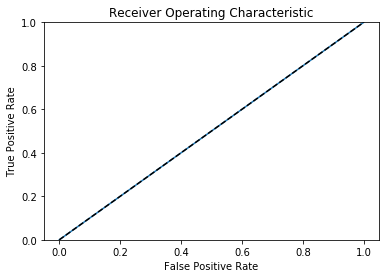

In [38]:
from sklearn.svm import SVC 
svc = SVC(C = 10, gamma= "auto", kernel = "rbf")
run_model(svc, x_train, x_test, y_train, y_test)


## AdaboostClassifier

AUC is:  0.5
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        25

   micro avg       0.68      1.00      0.81        25
   macro avg       0.68      1.00      0.81        25
weighted avg       0.68      1.00      0.81        25

Confusion Matrix: 
 [[25  0]
 [12  0]]


SVC(C=10, gamma='auto')

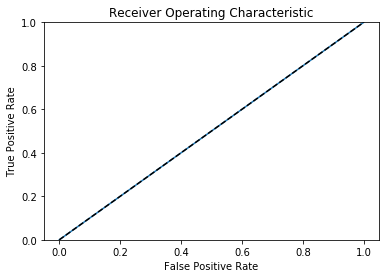

In [39]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1)

run_model(svc, x_train, x_test, y_train, y_test)

# Decision Tree

In [87]:
from sklearn.tree import DecisionTreeClassifier

def find_best_tree_model(upper_depth, upper_leaf):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=42, max_depth=depth, min_samples_leaf=leaf) 
            
            f1_scores, recall_scores = k_cross(model, x_train, y_train)
            f1 = np.mean(f1_scores)
            recall = np.mean(recall_scores)
            
            if f1 > best_f1:
                print(f"depth: {depth}, leaf: {leaf}: f1 = {f1} > best f1 = {best_f1}")
                best_f1 = f1
                best_f1_model = model
                
            if recall > best_recall:
                print(f"depth: {depth}, leaf: {leaf}: recall = {recall} > best recall = {best_recall}")
                best_recall = recall
                best_recall_model = model
    
    return best_f1_model, best_recall_model

best_tree_f1_model, best_tree_recall_model = find_best_tree_model(20, 30)

depth: 1, leaf: 1: f1 = 0.075 > best f1 = -1
depth: 1, leaf: 1: recall = 0.07333333333333333 > best recall = -1
depth: 1, leaf: 9: f1 = 0.22833333333333333 > best f1 = 0.075
depth: 1, leaf: 9: recall = 0.22523809523809524 > best recall = 0.07333333333333333
depth: 1, leaf: 20: f1 = 0.27880952380952384 > best f1 = 0.22833333333333333
depth: 1, leaf: 20: recall = 0.2652380952380952 > best recall = 0.22523809523809524
depth: 1, leaf: 21: f1 = 0.3054761904761905 > best f1 = 0.27880952380952384
depth: 1, leaf: 21: recall = 0.2795238095238095 > best recall = 0.2652380952380952
depth: 1, leaf: 25: recall = 0.2842857142857143 > best recall = 0.2795238095238095
depth: 1, leaf: 30: f1 = 0.33238095238095244 > best f1 = 0.3054761904761905
depth: 1, leaf: 30: recall = 0.3176190476190476 > best recall = 0.2842857142857143
depth: 2, leaf: 11: recall = 0.3304761904761905 > best recall = 0.3176190476190476
depth: 2, leaf: 12: recall = 0.3504761904761905 > best recall = 0.3304761904761905
depth: 2, leaf

AUC is:  0.48666666666666664
              precision    recall  f1-score   support

           0       0.67      0.64      0.65        25
           1       0.31      0.33      0.32        12

    accuracy                           0.54        37
   macro avg       0.49      0.49      0.49        37
weighted avg       0.55      0.54      0.55        37

Confusion Matrix: 
 [[16  9]
 [ 8  4]]


DecisionTreeClassifier(max_depth=4, min_samples_leaf=13, random_state=42)

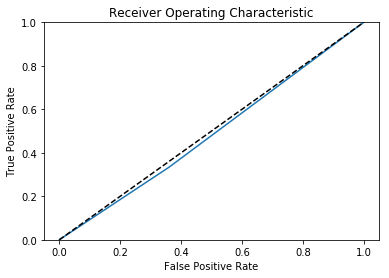

In [90]:
evaluate_model(best_tree_f1_model)

AUC is:  0.48666666666666664
              precision    recall  f1-score   support

           0       0.67      0.64      0.65        25
           1       0.31      0.33      0.32        12

    accuracy                           0.54        37
   macro avg       0.49      0.49      0.49        37
weighted avg       0.55      0.54      0.55        37

Confusion Matrix: 
 [[16  9]
 [ 8  4]]


DecisionTreeClassifier(max_depth=4, min_samples_leaf=13, random_state=42)

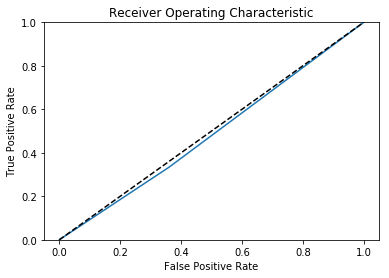

In [91]:
evaluate_model(best_tree_recall_model)

## Random Forest

In [97]:
from sklearn.ensemble import RandomForestClassifier

def find_best_forest_model(n_estimators):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestClassifier(random_state=42, n_estimators=estimator) 
        
        f1_scores, recall_scores = k_cross(model, x_train, y_train)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            print(f"estimator: {estimator}: f1 = {f1} > best f1 = {best_f1}")
            best_f1 = f1
            best_f1_model = model

        if recall > best_recall:
            print(f"estimator: {estimator}: recall = {recall} > best recall = {best_recall}")
            best_recall = recall
            best_recall_model = model
    
    return best_f1_model, best_recall_model

best_forest_f1_model, best_forest_recall_model = find_best_forest_model(20)

estimator: 1: f1 = 0.20771284271284274 > best f1 = -1
estimator: 1: recall = 0.20285714285714285 > best recall = -1


AUC is:  0.6916666666666668
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        25
           1       0.58      0.58      0.58        12

    accuracy                           0.73        37
   macro avg       0.69      0.69      0.69        37
weighted avg       0.73      0.73      0.73        37

Confusion Matrix: 
 [[20  5]
 [ 5  7]]


RandomForestClassifier(n_estimators=1, random_state=42)

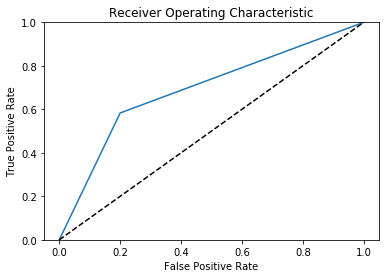

In [98]:
evaluate_model(best_forest_f1_model)